This notebook runs through the processing of reads from Trapnell's "The dynamics and regulators of cell fate decisions are revealed by pseudotemporal ordering of single cells".

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn import decomposition
from sklearn import cluster
import sklearn.metrics
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import entropy
from numpy.linalg import pinv
import operator
import itertools
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.cluster.hierarchy import *
import scipy.spatial.distance as ssd
import scipy
import colorsys

In [13]:
# Functions that are helpful for analysis

# obtain labels via kmeans
def jz_kmeans(X,k,num_iter=50):
    k_means = cluster.KMeans(n_clusters=k,max_iter=num_iter,precompute_distances=True)
    k_means.fit(X)
    labels = k_means.labels_
    return labels

# obtain labels via spectral clustering
def jz_spectral(X,k,D):
    # Compute pairwise distances
    #D = pairwise_distances(X,metric=dist_funct,n_jobs=nj)
    if D[1,1] < 1: D = np.exp(-D**2) # Convert distance to similarity matrix
    spectral = cluster.SpectralClustering(n_clusters=k,affinity='precomputed')
    spectral.fit(D)
    labels = spectral.labels_
    return labels,D

# Hierarchical clustering (generate linkage matrix encoding hierarchical clustering result)
def jz_hierclust(D):
    D_sym = 0.5*D+0.5*D.T
    # convert the redundant n*n square matrix form into a condensed nC2 array
    # distArray[{n choose 2}-{n-i choose 2} + (j-i-1)] is the distance between points i and j
    distArray = ssd.squareform(D_sym)
    z = linkage(distArray,method='complete')
    return z

# Given a linkage matrix, return cluster labels (k clusters)
def jz_linkage_to_labels(z,k):
    return fcluster(z,k,criterion='maxclust')

# Bicluster matrix R into k clusters
def jz_bicluster(R,k):
    model = SpectralCoclustering(n_clusters=k, random_state=0)
    model.fit(R)
    plot_biclusters(R,model.row_labels_,model.column_labels_)
    return model.row_labels_,model.column_labels_

# Plot biclusters:
def plot_biclusters(R,row_labels,col_labels):
    fit_data = R[np.argsort(row_labels)]
    fit_data = fit_data[:, np.argsort(col_labels)]
    plt.figure(figsize=(15,10))
    plt.matshow(fit_data, cmap=plt.cm.Blues)
    plt.title("After biclustering; rearranged to show biclusters")
    plt.show()

# NMF
def jz_NMF(X,n_topics=9):
    nmf = NMF(n_components=n_topics)
    nmf.fit(X)
    pinv_of_dict=pinv(nmf.components_)
    NMF_rep = np.transpose(pinv_of_dict)*np.transpose(X)
    return np.transpose(NMF_rep)

# obtain two major directions from t-SNE
def jz_tSNE(X):
    tsne = manifold.TSNE(n_components=2, random_state=0);
    X_tsne = tsne.fit_transform(X);
    return X_tsne

# obtain two major directions from t-SNE
def tSNE_pairwise(D):
    tsne = manifold.TSNE(n_components=2, random_state=0, metric='precomputed', n_iter=2000);
    X_tsne = tsne.fit_transform(D);
    return X_tsne

# Distance metrics (input: X with m samples, output: m-by-m distance matrix)
def shannon_jensen(p, q):
    m=0.5*p+0.5*q
    p = np.transpose(p[p > 0])
    q = np.transpose(q[q > 0])
    m = np.transpose(m[m > 0])
    return np.sqrt(entropy(m)-0.5*entropy(q)-0.5*entropy(p))

# Plot function with colors corresponding to labels (first two columns of X)
def jz_plot(X,labels):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15,10))
    for label in unique_labels:
        ind = np.squeeze(labels == label)
        plt.scatter(X[ind,0],X[ind,1],c=np.random.rand(3))


# Plot function with (nonrandom) colors corresponding to labels (stain plots stars in a specific label)
def stain_plot(X,labels,stain):
    unique_labels = np.unique(labels)
    N = len(unique_labels)
    max_value = 16581375 #255**3
    interval = int(max_value / N)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]    
    color= [(int(i[:2], 16)/float(255), int(i[2:4], 16)/float(255), int(i[4:], 16)/float(255)) for i in colors]
    i=0;
    plt.figure(figsize=(15,10))
    for label in unique_labels:
        ind = np.squeeze(labels == label)
        if label in stain: 
            plt.scatter(X[ind,0],X[ind,1],c='red',s=186,edgecolors='black',lw = 0.5, alpha=1,marker='*',label=label)
        else:
            plt.scatter(X[ind,0],X[ind,1],c=color[i],s=36,edgecolors='gray',lw = 0.5,label=label)
        
        i=i+1

#Compute the error rates of two classification schemes.
#Rather than going over m! possibilities where m is the number of classes
#this uses the heuristic of comparing the i th largest cluster of on labeling scheme
#with the i th largest cluster of the other labelling scheme
def compare_labels(label1, label2):
    # quality control.. make sure inputs are np arrays and their lengths are equal
    nplabel1=np.array(label1)
    nplabel2=np.array(label2)
    assert len(label1)==len(label2)
    unique_labels1=np.unique(nplabel1)
    unique_labels2=np.unique(nplabel2)
    # Create two dictionaries that count the number of each unique label in the two label sets
    num_entries1={}
    num_entries2={}
    for label in unique_labels1:
        num_entries1[label] = len(nplabel1[nplabel1==label])
    for label in unique_labels2:
        num_entries2[label] = len(nplabel2[nplabel2==label])
    sorted_label1 = sorted(num_entries1.items(), key=operator.itemgetter(1))
    sorted_label2 = sorted(num_entries2.items(), key=operator.itemgetter(1))
    # Find and return the sum of the differences between the ith largest labelings for label1, label2
    difference=0
    for index in xrange(len(sorted_label1)):
         set1= set(np.flatnonzero(nplabel1==sorted_label1[index][0]))
         set2= set(np.flatnonzero(nplabel2==sorted_label2[index][0]))
         difference+=len(set1.symmetric_difference(set2))
    return difference/2

#gets max weight matching of a biparetite graph with row_label x column_label
#where the weight is given by the weight_matrix
def get_max_wt_matching(row_label,column_label, weight_matrix):
    # Create a bipartite graph where each group has |unique labels| nodes
    G = nx.complete_bipartite_graph(len(row_label), len(column_label))
    # Weight each edge by the weight in weight  matrix.. 
    for u,v in G.edges():
        G[u][v]["weight"]=weight_matrix[u,v-len(row_label)]
    # Perform weight matching using Kuhn Munkres
    H=nx.max_weight_matching(G)
    max_wt=0
    for u,v in H.items():
        max_wt+=G[u][v]["weight"]/float(2)
    return max_wt

#Plot heatmap
def get_heatmap(data_matrix, row_labels, column_labels, ttl):
    plt_shape = (int(data_matrix.shape[0]*1.25),data_matrix.shape[1])
    fig, ax = plt.subplots(figsize=plt_shape)
    heatmap = ax.pcolor(data_matrix, cmap=plt.cm.Blues)
    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(data_matrix.shape[0])+0.5, minor=False)
    ax.set_yticks(np.arange(data_matrix.shape[1])+0.5, minor=False)
    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)
    plt.title(ttl+"\n",fontsize=14)
    plt.colorbar(heatmap)
    plt.show()
    
def analyse_labeling_schemes(label1, label2):
    # quality control.. make sure inputs are np arrays and their lengths are equal
    nplabel1=np.array(label1)
    nplabel2=np.array(label2)
    assert len(label1)==len(label2)
    unique_labels1=np.unique(nplabel1)
    unique_labels2=np.unique(nplabel2)
    # Create two dictionaries. Each will store the indices of each label
    entries1={}
    entries2={}
    for label in unique_labels1:
        entries1[label] = set(np.flatnonzero((nplabel1==label)))
    for label in unique_labels2:
        entries2[label] = set(np.flatnonzero((nplabel2==label)))
    # Create an intersection matrix which counts the number of entries that overlap for each label combination
    intersection_matrix=np.zeros((len(unique_labels1),len(unique_labels2)))
    for ind1,ind2 in itertools.product(range(len(unique_labels1)),range(len(unique_labels2))):
        intersection_matrix[ind1,ind2]=len(entries1[unique_labels1[ind1]].
                                               intersection(entries2[unique_labels2[ind2]]))
    # Plot a heatmap of the intersection matrix
    get_heatmap(intersection_matrix, unique_labels1, unique_labels2, 
                'Unnormalised heatmap of intersection of labels')
    get_heatmap(intersection_matrix/intersection_matrix.sum(axis=0), 
                unique_labels1, unique_labels2, 
               'Heatmap of intersection of labels normalised by labels along columns')
    get_heatmap((intersection_matrix.T/intersection_matrix.sum(axis=1)).T, 
                unique_labels1, unique_labels2,
               'Heatmap of intersection of labels normalised by labels along rows')
    # Print various error rates
    print "Error rates if best cluster index is picked row-wise : " + str(
        (1- sum(np.max(intersection_matrix, axis=0))/float(len(label1)))*100) + "%."
    print "Error rates if best cluster index is picked column-wise : " + str(
        (1- sum(np.max(intersection_matrix, axis=1))/float(len(label1)))*100) + "%."
    print "Error rates if best cluster index is picked using the Hungarian Algorithm : " + str(
        (1- get_max_wt_matching(unique_labels1,
                                unique_labels2,intersection_matrix)
         /float(len(label1)))*100) + "%."

In [14]:
# Load data
with open('/data/SS_RNA_seq/Code/clustering_on_reads/Trapnell_sparse_eq_class.dat', 'rb') as infile:
    X = pickle.load(infile)
with open('/data/SS_RNA_seq/Code/clustering_on_reads/Trapnell_sparse_eq_class_unnormalised.dat', 'rb') as infile:
    Xu = pickle.load(infile)
# Load precomputed jensen_shannon distance matrix
with open('/data/SS_RNA_seq/Code/clustering_on_reads/Trapnell_SJ.dat', 'rb') as infile:
    D = pickle.load(infile)

# Sanity checks on dimensions of loaded data:
print np.shape(X)
print np.shape(D)
print np.shape(Xu)

(384, 1101805)
(384, 384)
(384, 1101805)


Load subsampled data

In [15]:
num_reads=Xu.sum(axis=1)
#print num_reads
cells_sorted_by_num_reads=sorted(range(len(num_reads)), key=lambda k: num_reads[k], reverse=True)
print cells_sorted_by_num_reads

[382, 381, 383, 375, 377, 379, 373, 380, 376, 374, 378, 372, 364, 119, 279, 83, 32, 10, 89, 128, 57, 255, 111, 285, 70, 95, 305, 321, 269, 158, 121, 346, 12, 182, 367, 13, 24, 339, 356, 287, 231, 130, 60, 100, 88, 179, 217, 68, 188, 256, 114, 122, 37, 155, 58, 134, 61, 132, 344, 219, 343, 252, 237, 64, 186, 261, 127, 71, 309, 175, 43, 56, 163, 5, 278, 145, 360, 34, 297, 251, 359, 204, 54, 55, 152, 63, 275, 157, 28, 109, 92, 26, 341, 298, 368, 48, 97, 299, 50, 312, 300, 62, 53, 52, 170, 258, 245, 230, 371, 227, 79, 276, 87, 116, 351, 74, 280, 136, 203, 331, 18, 154, 370, 80, 191, 29, 17, 226, 115, 139, 102, 91, 159, 264, 124, 78, 235, 2, 42, 162, 31, 49, 361, 46, 262, 254, 59, 347, 259, 354, 282, 30, 41, 260, 229, 118, 314, 184, 146, 365, 148, 363, 197, 201, 315, 268, 82, 167, 51, 112, 327, 303, 120, 84, 239, 40, 133, 288, 142, 228, 270, 36, 213, 225, 76, 178, 6, 47, 316, 207, 20, 160, 218, 250, 96, 236, 0, 141, 253, 304, 9, 274, 19, 345, 281, 302, 181, 330, 324, 194, 144, 135, 247, 209

In [8]:
# Load data
with open('/data/SS_RNA_seq/Code/clustering_on_reads/Trapnell_sparse_eq_class_subsample20.dat', 'rb') as infile:
    X20 = pickle.load(infile)
    
with open('/data/SS_RNA_seq/Code/clustering_on_reads/Trapnell_sparse_eq_class_unnormalised_subsample20.dat'
          , 'rb') as infile:
    X20u = pickle.load(infile)

# Load precomputed jensen_shannon distance matrix
with open('/data/SS_RNA_seq/Code/clustering_on_reads/Trapnell_SJ_subsample20.dat', 'rb') as infile:
    D20 = pickle.load(infile)
    
# Load data
with open('/data/SS_RNA_seq/Code/clustering_on_reads/Trapnell_sparse_eq_class_subsample50.dat', 'rb') as infile:
    X50 = pickle.load(infile)

with open('/data/SS_RNA_seq/Code/clustering_on_reads/Trapnell_sparse_eq_class_unnormalised_subsample50.dat'
          , 'rb') as infile:
    X50u = pickle.load(infile)

# Load precomputed jensen_shannon distance matrix
with open('/data/SS_RNA_seq/Code/clustering_on_reads/Trapnell_SJ_subsample50.dat', 'rb') as infile:
    D50 = pickle.load(infile)
    
# Load data
with open('/data/SS_RNA_seq/Code/clustering_on_reads/Trapnell_sparse_eq_class_subsample80.dat', 'rb') as infile:
    X80 = pickle.load(infile)

with open('/data/SS_RNA_seq/Code/clustering_on_reads/Trapnell_sparse_eq_class_unnormalised_subsample80.dat'
          , 'rb') as infile:
    X80u = pickle.load(infile)

# Load precomputed jensen_shannon distance matrix
with open('/data/SS_RNA_seq/Code/clustering_on_reads/Trapnell_SJ_subsample80.dat', 'rb') as infile:
    D80 = pickle.load(infile)
    
#sanity checks
print X20.shape
print X50.shape
print X80.shape

print X20u.shape
print X50u.shape
print X80u.shape

print D20.shape
print D50.shape
print D80.shape

(384, 932034)
(384, 1022107)
(384, 1075158)
(384, 932034)
(384, 1022107)
(384, 1075158)
(384, 384)
(384, 384)
(384, 384)


In [9]:
plt.figure(figsize=(15,10))
plt.imshow(D)
plt.colorbar()

RuntimeError: Invalid DISPLAY variable

In [10]:
X_tsne = tSNE_pairwise(D)

In [36]:
# obtain two major directions from MDS
def vn_MDS(D):
    mds = manifold.MDS(n_components=2, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=12, random_state=None, dissimilarity='precomputed');
    X_mds = mds.fit_transform(D);
    return X_mds
# obtain two major directions from MDS
def vn_ICA(X):
    ica = decomposition.FastICA(n_components=2)
    X_mds = ica.fit_transform(X);
    return X_mds

In [32]:
X_mds =vn_MDS(D)

In [40]:
X_ica = vn_ICA(X.todense())   #very slow...

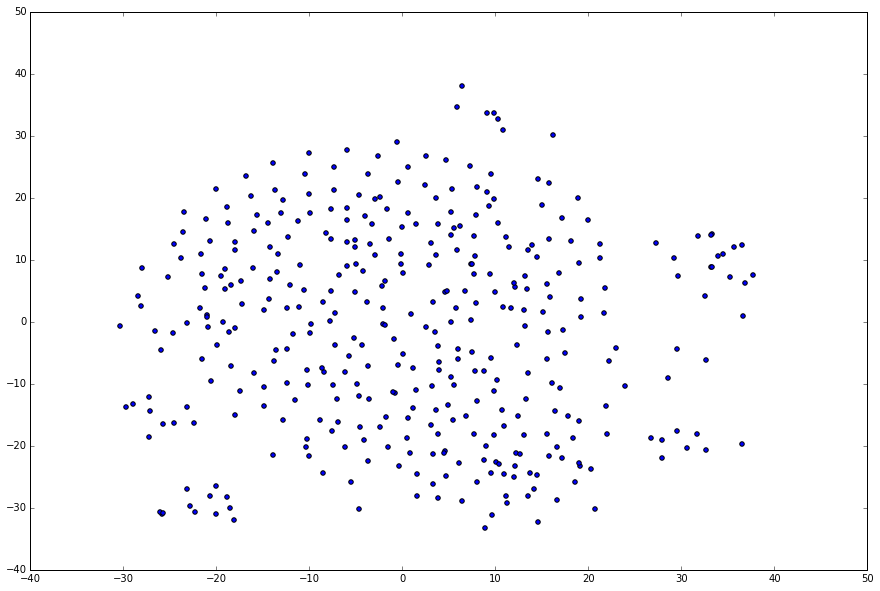

In [10]:
%matplotlib inline
plt.figure(figsize=(15,10))
plt.scatter(X_tsne[:,0],X_tsne[:,1])

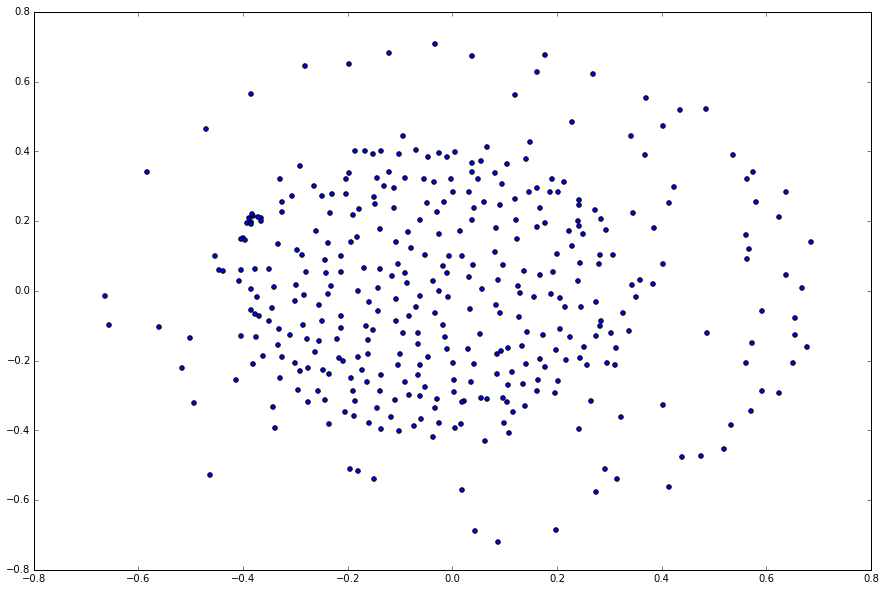

In [33]:
plt.figure(figsize=(15,10))
plt.scatter(X_mds[:,0],X_mds[:,1])

(-0.08, 0.12)

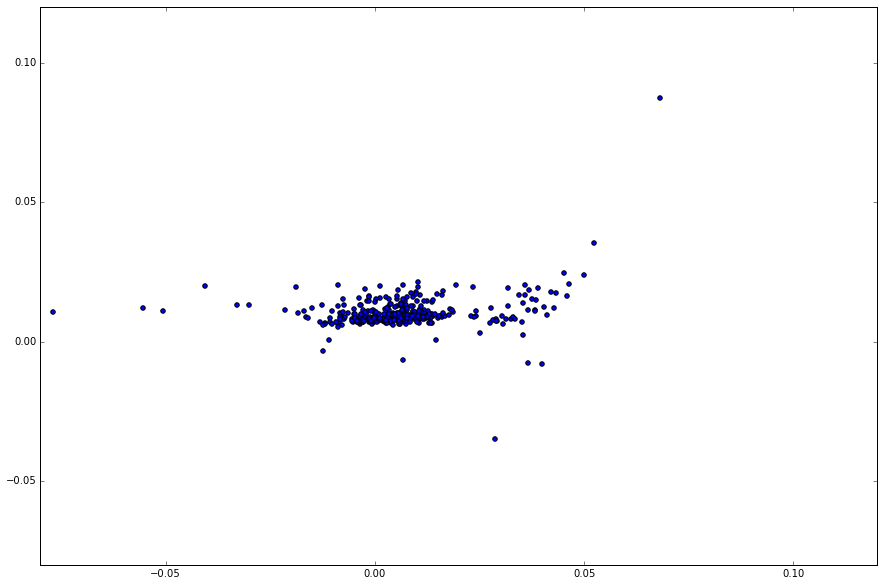

In [45]:
plt.figure(figsize=(15,10))
plt.scatter(X_ica[:,0],X_ica[:,1])
plt.xlim(-.08, 0.12)
plt.ylim(-.08, .12)

In [49]:
labels_spectral_3, similarity_matrix_l1=jz_spectral(X,4,D)

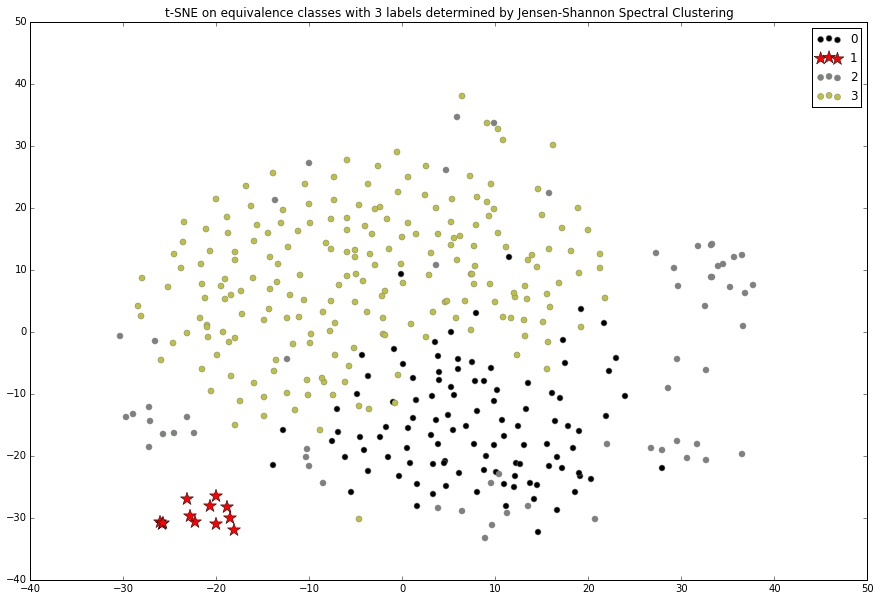

In [50]:
stain_plot(X_tsne,labels_spectral_3,[1])
plt.title('t-SNE on equivalence classes with 3 labels determined by Jensen-Shannon Spectral Clustering')
plt.legend(loc='upper right',bbox_to_anchor=(1, 1),ncol=1)

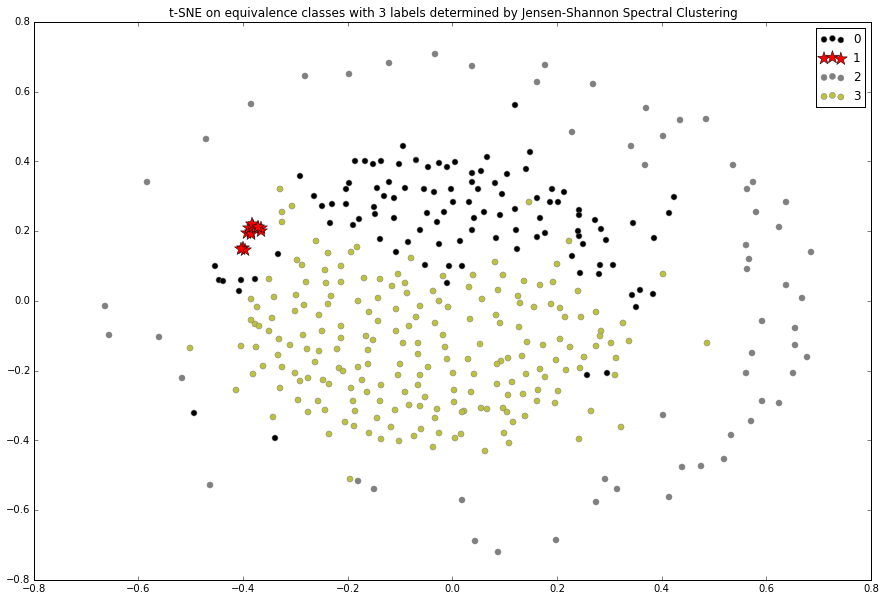

In [51]:
stain_plot(X_mds,labels_spectral_3,[1])
plt.title('MDS on equivalence classes with 3 labels determined by Jensen-Shannon Spectral Clustering')
plt.legend(loc='upper right',bbox_to_anchor=(1, 1),ncol=1)

(-0.08, 0.12)

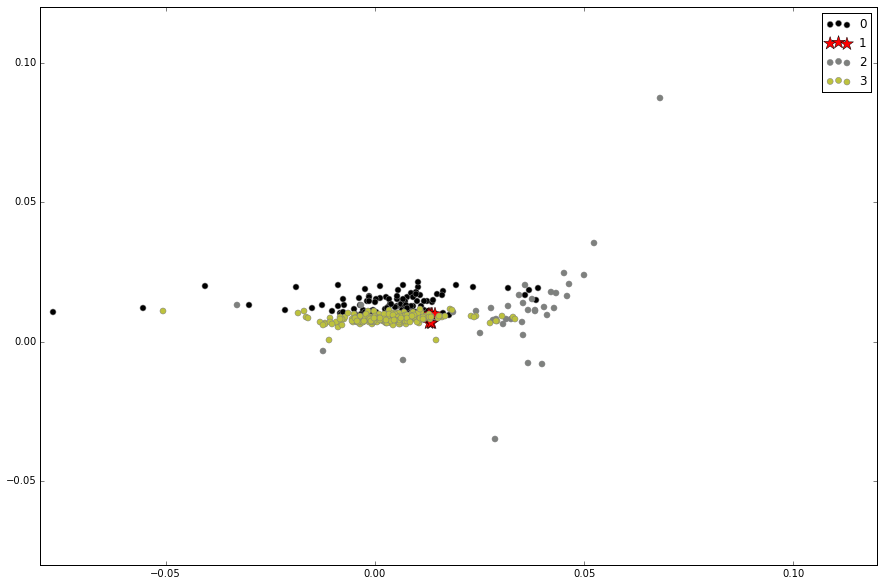

In [54]:
stain_plot(X_ica,labels_spectral_3,[1])
plt.legend(loc='upper right',bbox_to_anchor=(1, 1),ncol=1)
plt.xlim(-.08, 0.12)
plt.ylim(-.08, .12)

In [55]:
print labels_spectral_3 == 1


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [1]:
sum(labels_spectral_3 == 1)

NameError: name 'labels_spectral_3' is not defined

In [60]:
sum(labels_spectral_3 == 0)

106

In [61]:
sum(labels_spectral_3 == 2)

60

In [62]:
sum(labels_spectral_3 == 3)

206

In [5]:
Y=np.loadtxt('/data/SS_RNA_seq/Trapnell/GSE52529_fpkm_matrix.txt',skiprows=1,dtype=str)

In [6]:
Y=Y[:,1:].astype(np.float)

In [10]:
Y_tsne=jz_tSNE(Y.T)

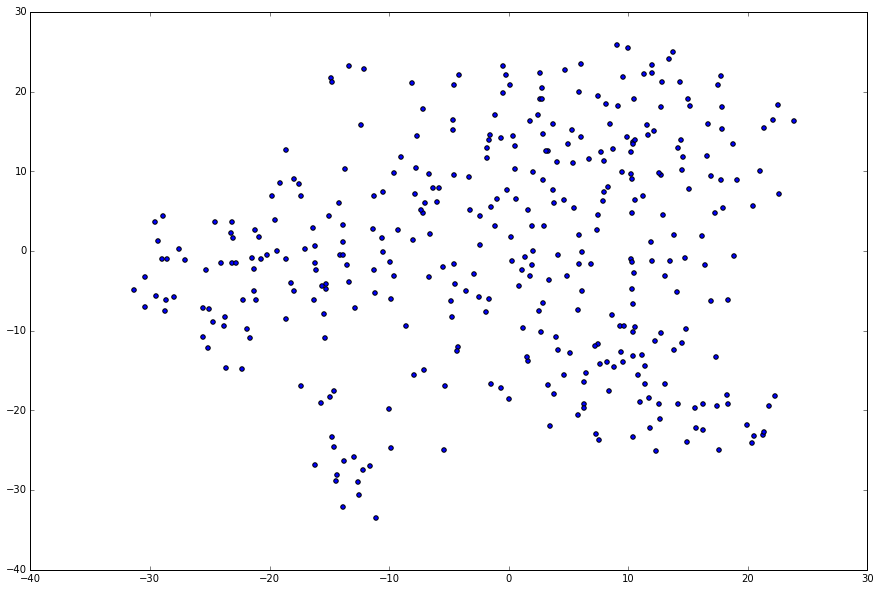

In [12]:
%matplotlib inline
plt.figure(figsize=(15,10))
plt.scatter(Y_tsne[:,0],Y_tsne[:,1])